In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from spatialist import Raster, Vector
from spatialist.explorer import RasterViewer

### A small time series plotting example
Along with this package we provide a small data Sentinel-1 SAR data set acquired in Interferometric (IW) Ground Range Detected (GRD) mode. It shows a small area in the Camargue, Southern France.  
This data set contains all images acquired in the area from January 1st 2017 to December 31st 2017, a total of 160 time steps.  
Currently we are developing a time series visualization tool based on matplotlib. Here you can test its capabilities live..

In [2]:
dataset = 'tutorial_data/S1_GRD_VV_France_Camargue_2017-01-01_2017-12-31'

In [3]:
with Raster(dataset) as ras:
    print(ras)

class      : spatialist Raster object
dimensions : 100, 100, 160 (rows, cols, bands)
resolution : 20.0, -20.0 (x, y)
extent     : 603068.241, 605068.241, 4818654.701, 4820654.701 (xmin, xmax, ymin, ymax)
coord. ref.: +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs 
data source: /home/truc_jh/PycharmProjects/spatialist/tutorial_data/S1_GRD_VV_France_Camargue_2017-01-01_2017-12-31


#### time stamp parsing
The bands of our test dataset contain information about the acquisition time. In this case, it is in the format YYYYmmddTHHMMSS, e.g. 20170525T055204. We can pass a custom function to convert this time stamp string into a python datetime object via parameter `ts_convert`. This function needs to be able to convert a single band name into a datetime object, i.e. not a list of all names at once. The following function `ts` first uses  a [regular expression](https://docs.python.org/3/library/re.html) to search for the string part containing the time stamp and then parses a datetime object by defining the format of the time stamp, i.e. which part contains the year, month, etc. See [datetime.strptime](https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior).

In [4]:
import re
from datetime import datetime
def ts(bandname):
    match = re.search('[0-9T]{15}', bandname).group()
    return datetime.strptime(match, '%Y%m%dT%H%M%S')

The following is the core time series visualization tool of spatialist. It makes use of ipywidgets to make the plots interactive. In case the widgets don't start, execute the following and restart jupyter:
```console
jupyter nbextension install --py widgetsnbextension --user
jupyter nbextension enable widgetsnbextension --user --py
```

define a custom function to extend the basic plotting functionality:

In [5]:
import seaborn as sns

def histogram(axis, values):
    hist = sns.distplot(values, hist=True, kde=True,
                    bins=int(180 / 5), color='darkblue',
                    hist_kws={'edgecolor': 'black'},
                    kde_kws={'linewidth': 4},
                    ax=axis)
    hist.set(xlabel='backscatter [dB]', ylabel='density')

initialize the interactive plot:

<IPython.core.display.Javascript object>


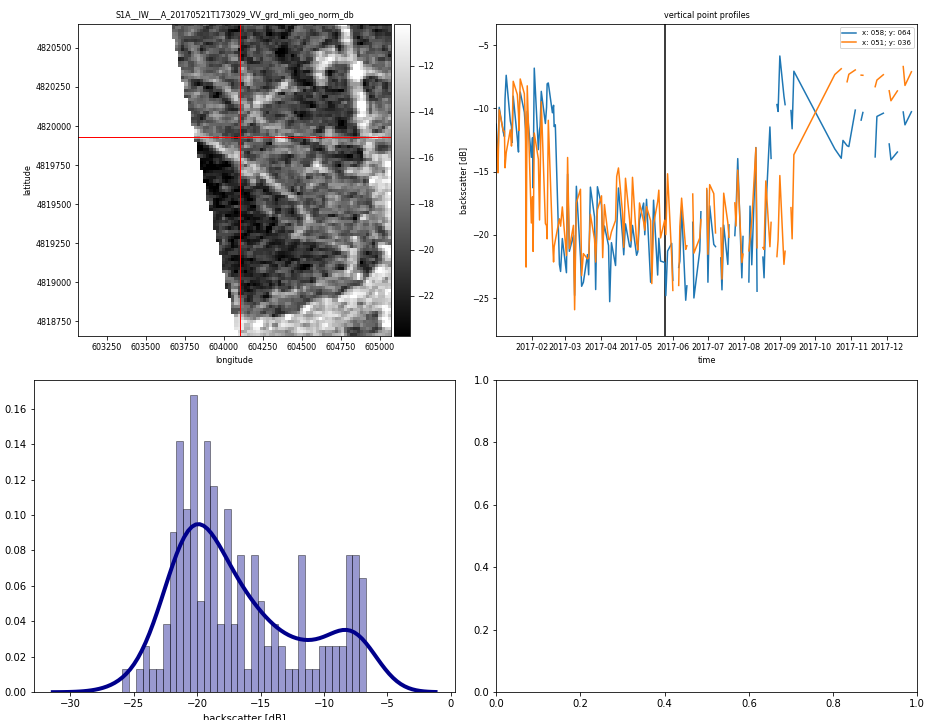

In [8]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (13, 10)
view = RasterViewer(dataset, cmap='gray', pmin=1, pmax=99, ts_convert=ts, 
                    title='S1 time series Camargue, France', datalabel='backscatter [dB]',
                    custom=[histogram])

### subsetting a raster object
In the following examples we want to subset our Raster data using pixel indices as well as vector data from a shapefile.  
first we display band 1 of the whole data set:

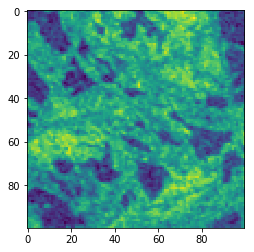

In [6]:
%matplotlib inline
with Raster(dataset) as ras:
    plt.imshow(ras.matrix(1))
    plt.show()

next we display a subset of this band:

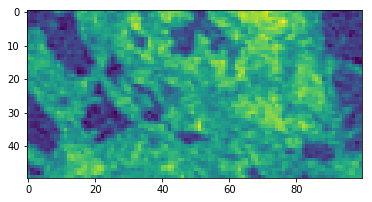

In [7]:
with Raster(dataset)[0:50,:,0] as ras:
    plt.imshow(ras.matrix())
    plt.show()

now we take a shapefile that is provided with this tutorial, subset the raster data with it and again display one of the layers. In this step, the Raster object is first subsetted to the extent of the vector bounding box and then all areas not overlapping with the shapefile geometries are masked.

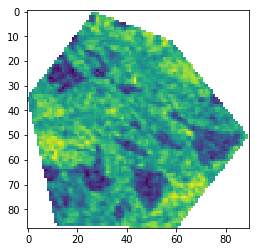

In [8]:
shapefile = 'tutorial_data/subset.shp'
with Raster(dataset) as ras:
    with Vector(shapefile) as vec:
        with ras[vec] as sub:
            plt.imshow(sub.matrix(band=1))
            plt.show()

Let's do something a bit more complex. In the following we define a second shapefile, compute this intersection of the two and use the intersection for subsetting our raster dataset.

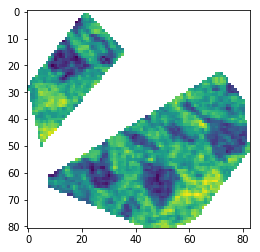

In [9]:
from spatialist.vector import intersect
shp2 = 'tutorial_data/subset2.shp'
with Raster(dataset) as ras:
    with Vector(shapefile) as vec1:
        with Vector(shp2) as vec2:
            with intersect(vec1, vec2) as inter:
                with ras[inter] as sub:
                    plt.imshow(sub.matrix(band=1))
                    plt.show()